# Entendimento do Negócio
- *Tema:*
> Análise de Críticas de espectadores e imprensa especializada em Filmes de Ficção Científica baseado no site
> adorocinema.com.
- *Problema:*
> Ler as críticas das páginas web, salvar em arquivo para avaliação e processar os dados de maneira a atingir o objetivo.
- *Objetivo:*
> Pontuar um filme entre 0.5 e 5 estrelas.

# Entendimento dos Dados
- *Formato*:
> As informações serão retiradas através de técnicas de crawler e scraping no site adorocinema.com.br levando em
> consideração apenas filmes da categoria 'Ficção Científica' e críticas da imprensa especializada e espectadores.
> Estes serão salvos em arquivo csv para utilização quando não for necessário a atualização dos dados.
- *Tamanho*:
> O tamanho dos dados são contemplados com a seleção da quantidade de páginas web de filmes do gênero de Ficção
> Científica que queremos avaliar.
- *Tipo dos Dados*:
> Os dados são formados por 5 atributos onde 4 são categóricos e 1 quantitativo.

# Biblioteca

In [1]:
import os
import re

import pandas as pd
import requests
import seaborn as sns
import spacy as sp
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, \
    RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from wordcloud import WordCloud

# Definição de Informações Estáticas

In [2]:
ESTADO = 1
ARQUIVO_DADOS = '../data/critica_filmes.csv'
FONTE = {
    'filme': "http://www.adorocinema.com/filmes/todos-filmes/notas-espectadores/genero-13021/?page=<PAGINA>",
    'imprensa': "http://www.adorocinema.com/filmes/<CODIGO>/criticas/imprensa/",
    'leitores': "http://www.adorocinema.com/filmes/<CODIGO>/criticas/espectadores/?page=<PAG_CRITICAS>"
}

# Desenvolvimento do Arquivo de Críticas

In [3]:
def retornar_pagina_web(endereco: str) -> BeautifulSoup:
    response = requests.get(endereco)
    return BeautifulSoup(response.text, 'html.parser') \
        if response.status_code == 200 and \
           (endereco == response.url or (len(endereco) - len(response.url)) == 7) else None

def retornar_base_dados(paginas) -> pd.DataFrame:
    filmes = list()
    for indx in range(1, paginas +1):
        bs = retornar_pagina_web(FONTE['filme'].replace('<PAGINA>', str(indx)))
        rs = bs(attrs={'class': 'no_underline'})
        for t in rs:
            filme = t.contents[0].strip()
            codigo = t.attrs['href'].split('/')[-2]

            indx1, bs1 = 0, BeautifulSoup()
            while not bs1 is None:
                indx1 += 1
                bs1 = retornar_pagina_web(FONTE['leitores'].replace('<CODIGO>', codigo).replace('<PAG_CRITICAS>', str(indx1)))
                if not bs1 is None:
                    rs1 = bs1(attrs={'class': 'hred review-card cf'})
                    for t1 in rs1:
                        filmes.append({
                            'codigo': codigo,
                            'filme': filme,
                            'fonte': t1.contents[1].contents[1].contents[3].contents[1].contents[1].contents[0].strip(),
                            'critica': t1.contents[3].contents[4].contents[0].strip() if t1.contents[3].contents[4].contents[0].strip() != '' else None,
                            'pontuacao': int(t1.contents[3].contents[1].contents[1].contents[0].attrs['class'][1][1:]) / 10
                        })

            bs1 = retornar_pagina_web(FONTE['imprensa'].replace('<CODIGO>', codigo))
            if not bs1 is None:
                rs1 = bs1(attrs={'class': 'item hred'})
                for t1 in rs1:
                    filmes.append({
                        'codigo': codigo,
                        'filme': filme,
                        'fonte': t1.contents[1].contents[0].strip(),
                        'critica': t1.contents[5].contents[0].strip() if t1.contents[5].contents[0].strip() != '' \
                            else None,
                        'pontuacao': int(t1.contents[3].contents[1].contents[0].attrs['class'][1][1:]) / 10
                    })
    return pd.DataFrame(filmes)

In [4]:
atualizar = 's' if not os.path.isfile(ARQUIVO_DADOS) else None
if atualizar is None:
    while not atualizar in ['s','n']:
        atualizar = input('Deseja atualizar os dados? (S/N): ').lower()
if atualizar == 's':
    paginas_web_filmes = 0
    while paginas_web_filmes <= 0:
        try:
            paginas_web_filmes = int(input(f'Quantas páginas deseja avaliar?\nA quantidade máxima pode ser verificada no '
                                   f'link {FONTE["filme"][:-14]}. '))
        except:
            paginas_web_filmes = 0
    retornar_base_dados(paginas_web_filmes).to_csv(ARQUIVO_DADOS)

# Avaliação dos Dados

In [5]:
df_criticas = pd.read_csv('../data/critica_filmes.csv').rename({'Unnamed: 0': 'Indice'}, axis=1).set_index('Indice')

In [6]:
df_criticas.isnull().sum()

codigo        0
filme         0
fonte         0
critica      67
pontuacao     0
dtype: int64

In [7]:
df_criticas = df_criticas.loc[df_criticas.critica.notnull()]

In [8]:
df_criticas.codigo = df_criticas.codigo.apply(lambda codigo: df_criticas.codigo.unique().tolist().index(codigo))

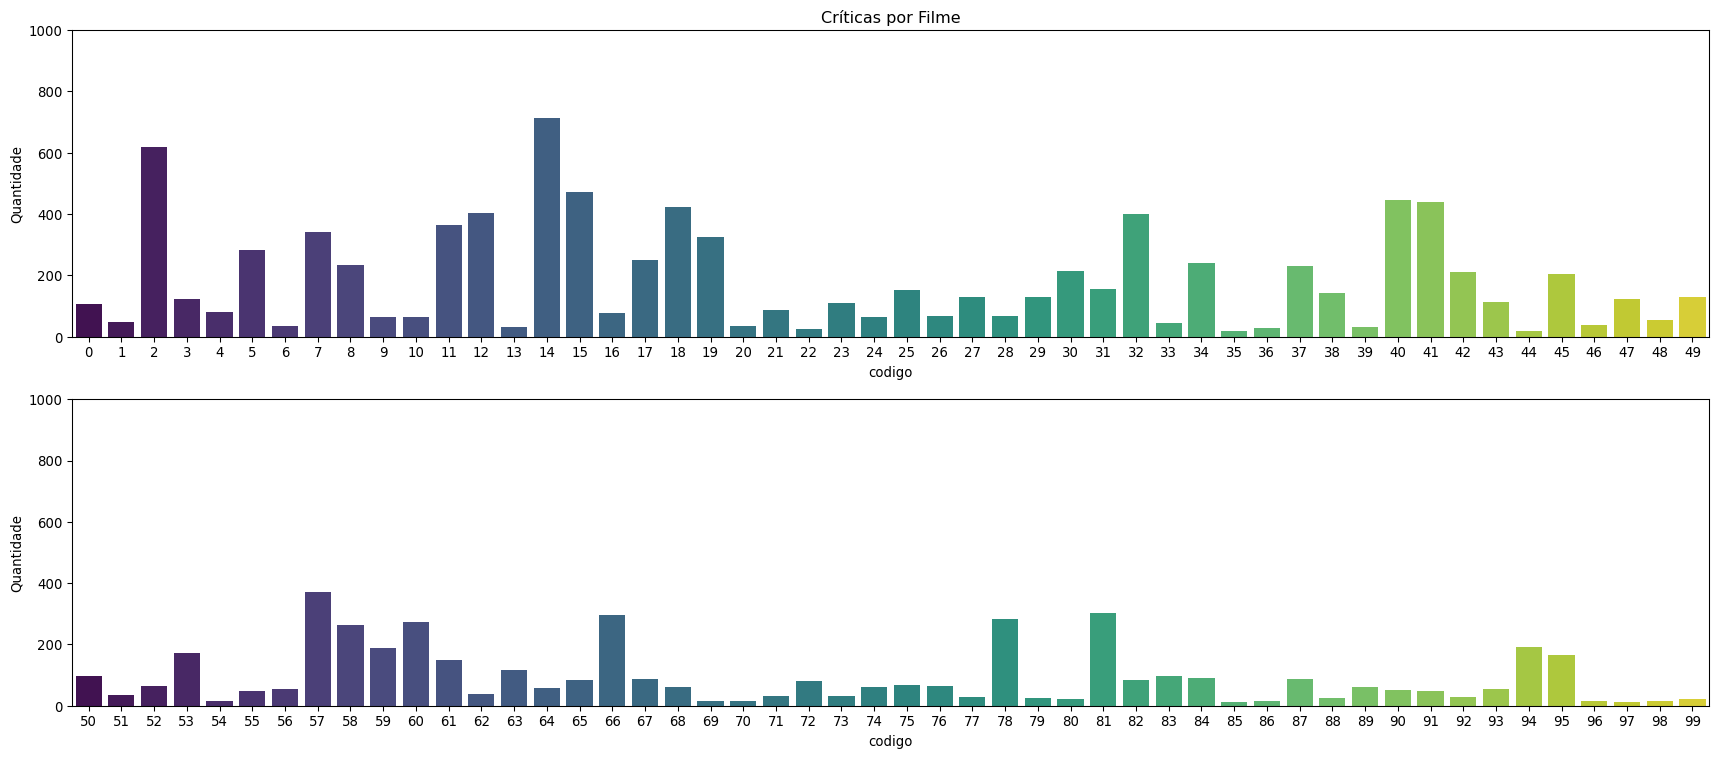

In [9]:
fig, [ax0, ax1] = plt.subplots(2, 1, dpi=96, figsize=(18, 8))
sns.countplot(x='codigo', data=df_criticas[['codigo', 'critica']].loc[df_criticas.codigo < 50], palette='viridis', ax=ax0)
ax0.set_ylim([0, 1000])
ax0.set_title('Críticas por Filme')
ax0.set_ylabel('Quantidade')
sns.countplot(x='codigo', data=df_criticas[['codigo', 'critica']].loc[df_criticas.codigo >= 50], palette='viridis', ax=ax1)
ax1.set_ylim([0, 1000])
ax1.set_ylabel('Quantidade')
plt.tight_layout();

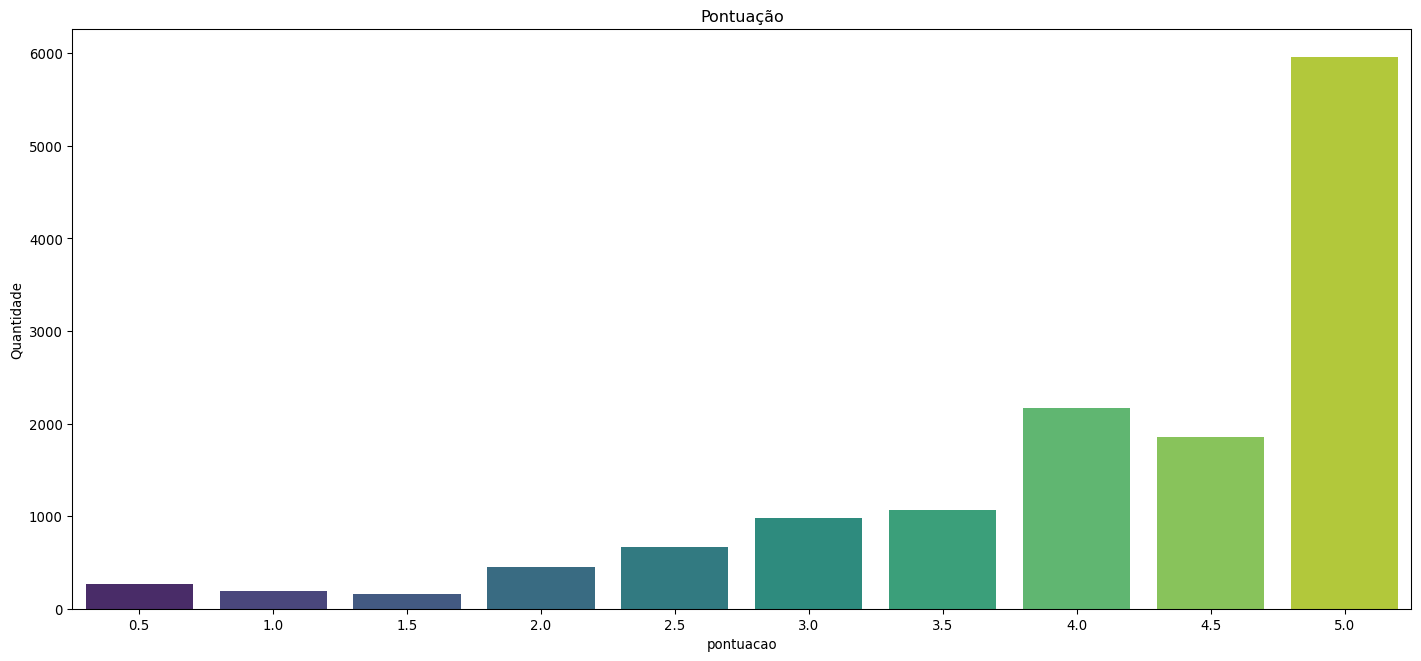

In [10]:
plt.figure(dpi=96, figsize=(18,8))
sns.countplot(x='pontuacao', data=df_criticas[['pontuacao']], palette='viridis')
plt.title('Pontuação')
plt.ylabel('Quantidade');

In [11]:
del ax0, ax1, fig

### Definição de Treino

In [12]:
resposta = None
while not resposta in ['s','n']:
    resposta = input('Deseja avaliar com uma base proporcional? (S/N): ').lower()
if resposta.lower() == 's':
    MINIMO = df_criticas[['pontuacao','codigo']].groupby('pontuacao').count().sort_values('codigo').min().values[-1]
    exemplos = list()
    for pontuacao in df_criticas.pontuacao.unique().tolist():
        exemplos.append(
            df_criticas.loc[df_criticas.pontuacao==pontuacao].sample(MINIMO).drop(['codigo', 'filme', 'fonte'], axis=1).copy()
        )
    df_criticas_treino = pd.concat(exemplos)
else:
    while not resposta.isdecimal():
        resposta = input(f'Informe a quantidade de registros que deseja utilizar (Max. {str(df_criticas.critica.count())}) :')
    df_criticas_treino = df_criticas.sample(int(resposta))

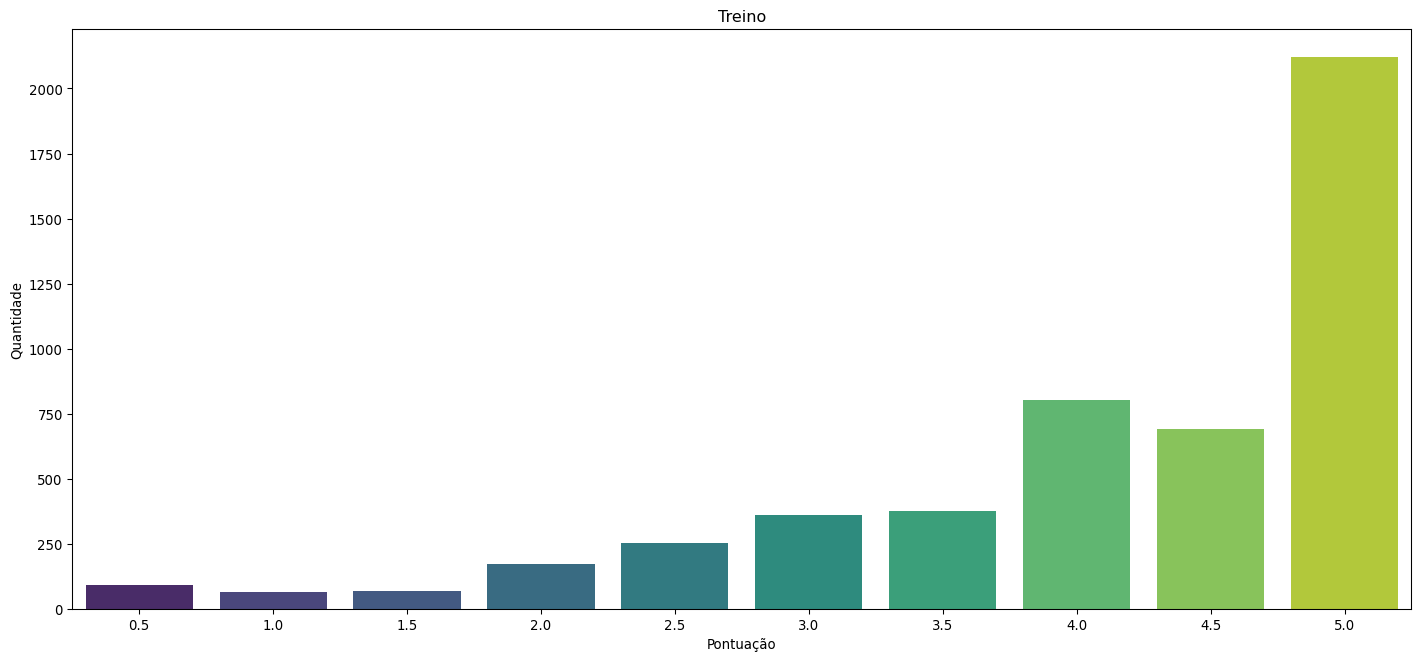

In [13]:
plt.figure(dpi=96, figsize=(18,8))
sns.countplot(x='pontuacao', data=df_criticas_treino, palette='viridis')
plt.title('Treino')
plt.ylabel('Quantidade')
plt.xlabel('Pontuação');

### Modelação dos Dados

In [14]:
nlp = sp.load('pt_core_news_md')
def vetorizar_texto(texto: str) -> list:
    texto = re.sub(r'\d+', ' ', texto)
    texto = re.sub(r'\W+', ' ', texto)
    texto = re.sub(r'\s', ' ', texto)
    texto = texto.lower().strip()
    for i in range(97, 123):
        j = 1 if not chr(i) in ['o','r','s'] else 3
        texto = re.sub(''.join([chr(i)*j, '+']), chr(i), texto)

    return [palavra.lemma_ for palavra in nlp(texto) if not palavra.is_stop and palavra.pos_ in ['ADJ','NOUM']]

In [15]:
vetorizacao = TfidfVectorizer(strip_accents='unicode', tokenizer=vetorizar_texto, ngram_range=(1, 2), max_features=60000)
sentencas = vetorizacao.fit_transform(df_criticas_treino.critica).toarray()

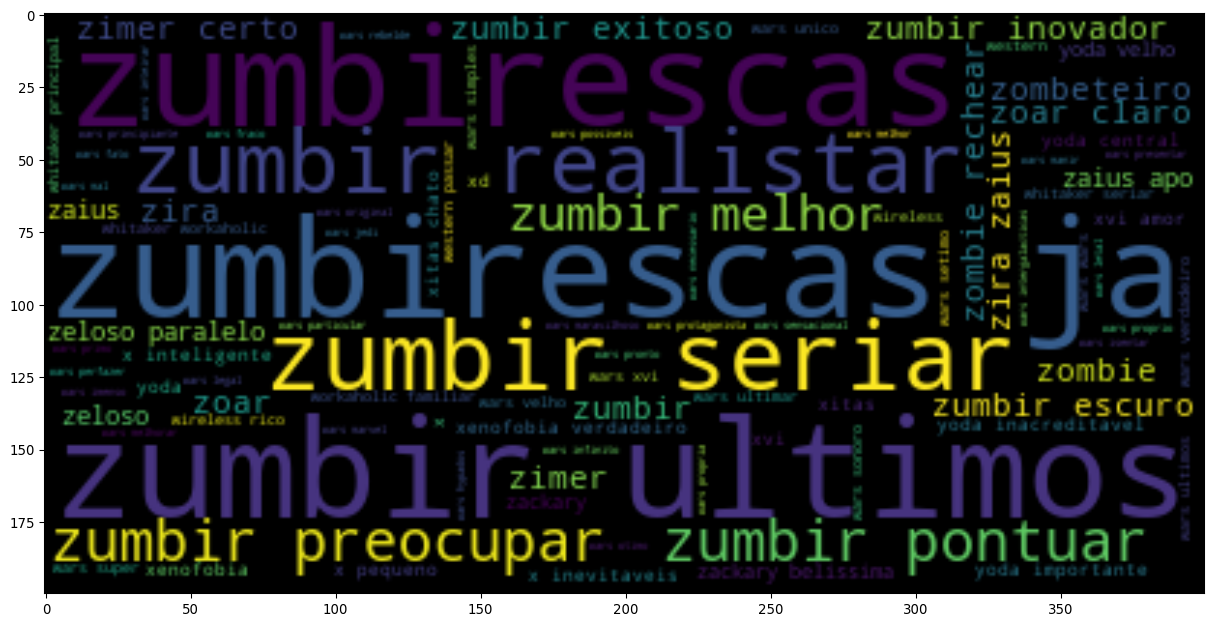

In [16]:
plt.figure(dpi=96, figsize=(18, 8))
plt.imshow(WordCloud().generate_from_frequencies(vetorizacao.vocabulary_), interpolation='bilinear');

# Avaliação de Modelos

In [17]:
def avaliar_modelos(modelos: list, sentencas) -> pd.DataFrame:
    resultado = list()
    for modelo in modelos:
        clf = modelo['modelo']()
        clf.fit(sentencas[0], sentencas[2])
        pred = clf.predict(sentencas[1])
        resultado.append({
            'modelo':  str(modelo['modelo']).split('.')[-1][:-2],
            'precisao': r2_score(y_true=sentencas[3], y_pred=pred),
            'instancia': clf
        })
    return pd.DataFrame(resultado)

def avaliar_exemplos(modelo):
    exemplos = [
        "Este filme é ótimo!",
        "Péssimo!! A história se perde a todo momento.",
        "Interessante, mas poderia ser bem melhor. Confuso, mas tem seus momentos legais.",
        "Filme fantástico. Fico no aguardo da continuação.",
        "Ruim, muito ruim mesmo, não recomendo."
    ]
    exemplos.append(input(f'Informe uma crítica sobre o filme "{df_criticas.filme.sample(1).values[-1]}": '))
    resultado = modelo.predict(pca.transform(vetorizacao.transform(exemplos).toarray()))
    for x in [' : '.join([str(round(resultado[indice], 2)), exemplo]) for indice, exemplo in enumerate(exemplos)]:
        print(x)

In [18]:
pca = PCA(n_components=2, random_state=ESTADO)
sentencas_pca = pca.fit_transform(sentencas)

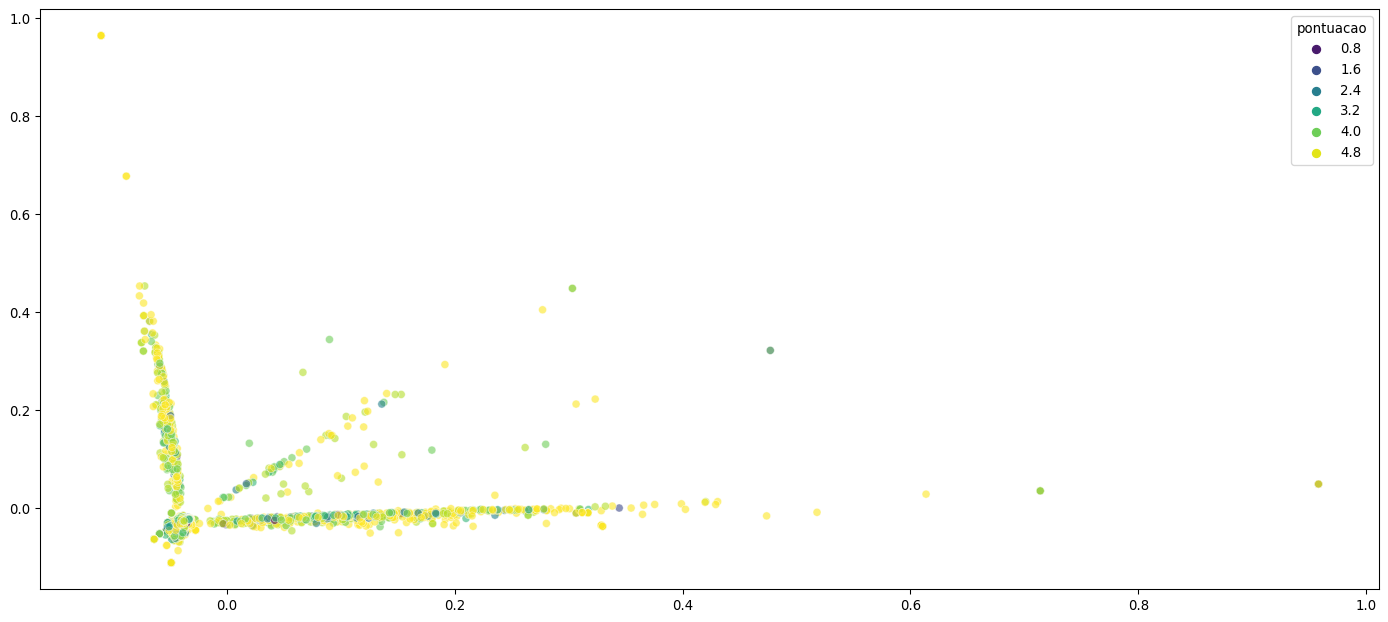

In [19]:
plt.figure(dpi=96, figsize=(18, 8))
sns.scatterplot(x=sentencas_pca[:,0], y=sentencas_pca[:,1], hue=df_criticas_treino.pontuacao, alpha=0.6, palette='viridis');

In [20]:
pca = PCA(n_components=120, random_state=ESTADO)
sentencas_pca = pca.fit_transform(sentencas)

In [21]:
sentencas_train_test = train_test_split(sentencas_pca, df_criticas_treino.pontuacao, test_size=0.3, random_state=ESTADO)

### Modelos de Regressão

In [22]:
modelos = [
    {
        'modelo': DecisionTreeRegressor,
        'parametros':
        {
            'criterion':['mse', 'friedman_mse', 'mae'],
            'max_depth': [None, 1, 5],
            'min_samples_split': [0, 2, 4],
            'min_samples_leaf': [0, 1, 2],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_leaf_nodes': [None, 1, 5, 10]
        }
    },
    {
        'modelo': KNeighborsRegressor,
        'parametros':
        {
            'n_neighbors':[1, 5, 10],
            'weights': ['uniform','distance'],
            'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size':[10, 30, 50],
            'p':[1, 2],
        }
    },
    {
        'modelo': RadiusNeighborsRegressor,
        'parametros':
        {
            'radius':[0.5, 1.0, 1.5],
            'weights': ['uniform','distance'],
            'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size':[10, 30, 50],
            'p':[1, 2],
        }
    },
    {
        'modelo': GaussianProcessRegressor,
        'parametros':
        {
            'kernel':[None, DotProduct(), WhiteKernel(), DotProduct() + WhiteKernel()],
            'random_state': [ESTADO]
        }
    },
    {
        'modelo': AdaBoostRegressor,
        'parametros':
        {
            'n_estimators': [10, 50, 90],
            'learning_rate': [0.5, 1.0, 1.5],
            'loss': ['linear', 'square', 'exponential'],
            'random_state': [ESTADO]
        }
    },
    {
        'modelo': BaggingRegressor,
        'parametros':
        {
            'n_estimators': [1, 10, 19],
            'max_samples': [0.5, 1.0, 1.5],
            'max_features': [0.5, 1.0, 1.5],
            'bootstrap':[True, False],
            'bootstrap_features': [False, True],
            'oob_score': [False, True],
            'warm_start': [False, True],
            'random_state': [ESTADO]
        }
    },
    {
        'modelo': ExtraTreesRegressor,
        'parametros':
        {
            'n_estimators': [50, 100, 150],
            'criterion': ['mse', 'mae'],
            'max_depth': [None, 1 , 5],
            'min_samples_split': [1, 2, 3],
            'min_samples_leaf': [0.5, 1, 1.5],
            'min_weight_fraction_leaf': [0.0, 0.5, 1.0],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_leaf_nodes': [None, 1, 5],
            'min_impurity_decrease': [0.0, 0.5],
            'bootstrap':[True, False],
            'oob_score': [False, True],
            'random_state': [ESTADO]
        }
    },
    {
        'modelo': GradientBoostingRegressor,
        'parametros':
        {
            'loss': ['ls', 'lad', 'huber', 'quantile'],
            'learning_rate': [0.05, 0.1, 0.5],
            'n_estimators' : [50, 100, 150],
            'subsample': [0.5, 1.0, 1.5],
            'criterion': ['friedman_mse', 'mse', 'mae'],
            'min_samples_split': [1, 2, 3],
            'min_samples_leaf': [0.5, 1, 1.5],
            'min_weight_fraction_leaf': [0.0, 0.5, 1],
            'max_depth': [1, 3, 5],
            'min_impurity_decrease': [0.0, 0.5],
            'max_leaf_nodes': [None, 1, 5],
            'random_state': [ESTADO]
        }
    },
    {
        'modelo': RandomForestRegressor,
        'parametros':
        {
            'n_estimators' : [50, 100, 150],
            'criterion': ['mse', 'mae'],
            'min_samples_split': [1, 2, 3],
            'min_samples_leaf': [0.5, 1, 1.5],
            'min_weight_fraction_leaf': [0.0, 0.5, 1],
            'max_depth': [None, 1, 3],
            'min_impurity_decrease': [0.0, 0.5],
            'max_leaf_nodes': [None, 1, 5],
            'max_features': ['auto', 'sqrt', 'log2'],
            'bootstrap':[True, False],
            'oob_score': [False, True],
            'random_state': [ESTADO]
        }
    }
]

In [23]:
predicao = avaliar_modelos(modelos, sentencas_train_test)
predicao[['modelo','precisao']].sort_values('precisao', ascending=False)

,modelo,precisao
7,GradientBoostingRegressor,0.258173
8,RandomForestRegressor,0.203328
6,ExtraTreesRegressor,0.196388
5,BaggingRegressor,0.121497
1,KNeighborsRegressor,0.118210
4,AdaBoostRegressor,0.055275
2,RadiusNeighborsRegressor,0.003437
0,DecisionTreeRegressor,-0.454814
3,GaussianProcessRegressor,-1262.426940


In [24]:
modelo = modelos[predicao.loc[predicao.precisao==predicao.precisao.max()].index.values[-1]]

In [25]:
avaliar_exemplos(predicao['instancia'].values[-1])

4.47 : Este filme é ótimo!
0.83 : Péssimo!! A história se perde a todo momento.
3.09 : Interessante, mas poderia ser bem melhor. Confuso, mas tem seus momentos legais.
4.34 : Filme fantástico. Fico no aguardo da continuação.
2.25 : Ruim, muito ruim mesmo, não recomendo.
4.12 : Bom filme.


### Modelos de Regressão com Hiper Parâmetros

In [26]:
while not resposta in ['s', 'n']:
    resposta = input('Deseja avaliar a hiper parametrização? (S/N): ').lower()
if resposta == 's':
    modelo = modelos[predicao.loc[predicao.precisao==predicao.precisao.max()].index.values[-1]]
    gs = GridSearchCV(
        estimator=modelo['modelo'](),
        param_grid=modelo['parametros'],
        scoring='r2',
        n_jobs=-1,
        cv=KFold(n_splits=10, random_state=ESTADO),
        verbose=1
    )
    gs.fit(sentencas_train_test[0], sentencas_train_test[2])
    print(modelo['modelo'], '\nMelhores parâmetros:', gs.best_params_, '\nPrecisão', gs.best_score_)
    avaliar_exemplos(gs)